In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import time

start = time.time()

In [2]:
#''' Single ONU data ProcessReport_32_ONUs_RequestSize_OLT_DBA ProcessGate_ONU16_request
text_file = open("./SelfData/0613/SendReport_ONU16_BufferSize.txt","r")#ONU_16_GrantDownLoadSizePerCycle, ONU[27]_GrantDown.txt
lines = text_file.readlines()
i = 1

Down64GB = []
Down80GB = []
Down96GB = []
Down112GB = []
Down128GB = []

EPON_data = []


i = 0
for line in lines:
    if i < 50000:
        n = float(line)
        if(n > 195000.0):
            Down64GB.append(195000.0)
        else: #elif n >= 0:
            Down64GB.append(n)
    i = i + 1

print(len(Down64GB))
print(len(Down80GB))
print(len(Down96GB))
print(len(Down112GB))
print(len(Down128GB))
print(Down64GB[0:10])
print('max: ',max(Down64GB))
#'''

21827
0
0
0
0
[6584.0, 0.0, 4115.0, 2469.0, 4115.0, 823.0, 5761.0, 5761.0, 0.0, 3292.0]
max:  28805.0


In [3]:
#Down64GB = Down64GB[3307:]  # SimT >= 1 
Down64GB = Down64GB[0:50000]

Down64GB = np.array(Down64GB) #Total 4974, Train : 3974, Test : 1000
Down80GB = np.array(Down80GB) #Total 5077, Train : 4077, Test : 1000
Down96GB = np.array(Down96GB) #Total 5186, Train : 4186, Test : 1000
Down112GB = np.array(Down112GB) #Total 5154, Train : 4154, Test : 1000
Down128GB = np.array(Down128GB) #Total 4775, Train : 3875, Test : 900
data64GB = []
data80GB = []
data96GB = []
data112GB = []
data128GB = []

data = []
data_size = len(Down64GB)     ####
train_size = data_size - 4365  ### 
test_size = 4365   ###8G-1 = 7456, 8G-2 = 7450 
timesteps_ = 10               #
print('data_size : ',data_size)
print('train_size : ',train_size)
print('test_size : ',test_size)

for info in Down64GB:         ####
    data.append(info) 

data = np.array(data) 
data[20:40]
data = np.reshape(data,(data_size,1))  
#data[20:40]

data_size :  21827
train_size :  17462
test_size :  4365


In [4]:
TrainSet, TestSet = np.zeros(train_size), np.zeros(test_size)
TrainSet, TestSet = data[0:len(TrainSet)], data[len(TrainSet):data.shape[0]]
TrainSet, TestSet = np.array(TrainSet), np.array(TestSet)
TrainSet, TestSet = np.reshape(TrainSet,(len(TrainSet),1)), np.reshape(TestSet,(len(TestSet),1))

X_train = []
Y_train = []

In [5]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0,1))
TrainSet = sc.fit_transform(TrainSet)

period = timesteps_
end_of_TrainSet = train_size

print('type(TrainSet) : ',type(TrainSet))
print('TrainSet.shape : ',TrainSet.shape)

for i in range(period,end_of_TrainSet): #
    X_train.append(TrainSet[i-period:i,0])
    Y_train.append(TrainSet[i,0])

print('type(X_train) : ',type(X_train))
print('type(Y_train) : ',type(Y_train))    
    
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_train = np.reshape(X_train,(X_train.shape[0], X_train.shape[1], 1))

type(TrainSet) :  <class 'numpy.ndarray'>
TrainSet.shape :  (17462, 1)
type(X_train) :  <class 'list'>
type(Y_train) :  <class 'list'>


In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
'''
regressor = Sequential()

regressor.add(LSTM(units = 40, return_sequences = True, input_shape = (X_train.shape[1],1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 40, return_sequences = True))
regressor.add(Dropout(0.2))
              
regressor.add(LSTM(units = 40, return_sequences = True))
regressor.add(Dropout(0.2)) 

regressor.add(LSTM(units = 40))
regressor.add(Dropout(0.2))

regressor.add(Dense(units = 1))

regressor.compile(optimizer = 'adam', loss = 'mean_absolute_error',metrics=['mse','mae'])#  mean_absolute_error mean_squared_error huber

history = regressor.fit(X_train,Y_train,epochs = 100, batch_size = 32)
'''
inputs = Input(shape=(timesteps_,))
#inputs = LayerNormalization(axis=1)(inputs)
tgt1 = tf.keras.layers.Reshape((timesteps_,1),input_shape=(timesteps_,))(inputs)

tgt1 = LSTM(units=32, return_sequences = True, input_shape=(timesteps_,1))(tgt1)
tgt1 = Dropout(0.2)(tgt1)

#tgt2 = LSTM(units=40, return_sequences = True)(tgt1)
#tgt2 = Dropout(0.2)(tgt2)

#tgt3 = LSTM(units=40, return_sequences = True)(tgt2)
#tgt3 = Dropout(0.2)(tgt3)

tgt4 = LSTM(units=32)(tgt1)
tgt4 = Dropout(0.2)(tgt4)

predictions = Dense(1, activation='relu')(tgt4) #, activation='relu'

model = Model(inputs=inputs, outputs=predictions)
model.compile(loss='mean_squared_error', optimizer='Adam',metrics=['mse','mae']) #Adam or AdaGrad

history = model.fit(X_train, Y_train, epochs=100, batch_size=32, validation_split=0.2) #[1,0,0], [0,0,1]

Epoch 1/100
437/437 [==============================] - 2s 5ms/step - loss: 0.0091 - mse: 0.0091 - mae: 0.0727 - val_loss: 0.0079 - val_mse: 0.0079 - val_mae: 0.0733
Epoch 2/100
437/437 [==============================] - 2s 4ms/step - loss: 0.0079 - mse: 0.0079 - mae: 0.0678 - val_loss: 0.0071 - val_mse: 0.0071 - val_mae: 0.0673
Epoch 3/100
437/437 [==============================] - 2s 4ms/step - loss: 0.0075 - mse: 0.0075 - mae: 0.0655 - val_loss: 0.0069 - val_mse: 0.0069 - val_mae: 0.0654
Epoch 4/100
437/437 [==============================] - 2s 4ms/step - loss: 0.0073 - mse: 0.0073 - mae: 0.0649 - val_loss: 0.0069 - val_mse: 0.0069 - val_mae: 0.0661
Epoch 5/100
437/437 [==============================] - 2s 4ms/step - loss: 0.0074 - mse: 0.0074 - mae: 0.0649 - val_loss: 0.0070 - val_mse: 0.0070 - val_mae: 0.0670
Epoch 6/100
437/437 [==============================] - 2s 4ms/step - loss: 0.0073 - mse: 0.0073 - mae: 0.0648 - val_loss: 0.0070 - val_mse: 0.0070 - val_mae: 0.0638
Epoch 7/10

437/437 [==============================] - 2s 4ms/step - loss: 0.0067 - mse: 0.0067 - mae: 0.0578 - val_loss: 0.0065 - val_mse: 0.0065 - val_mae: 0.0593
Epoch 51/100
437/437 [==============================] - 2s 4ms/step - loss: 0.0066 - mse: 0.0066 - mae: 0.0574 - val_loss: 0.0065 - val_mse: 0.0065 - val_mae: 0.0600
Epoch 52/100
437/437 [==============================] - 2s 4ms/step - loss: 0.0067 - mse: 0.0067 - mae: 0.0575 - val_loss: 0.0065 - val_mse: 0.0065 - val_mae: 0.0591
Epoch 53/100
437/437 [==============================] - 2s 4ms/step - loss: 0.0067 - mse: 0.0067 - mae: 0.0575 - val_loss: 0.0064 - val_mse: 0.0064 - val_mae: 0.0594
Epoch 54/100
437/437 [==============================] - 2s 4ms/step - loss: 0.0067 - mse: 0.0067 - mae: 0.0577 - val_loss: 0.0066 - val_mse: 0.0066 - val_mae: 0.0629
Epoch 55/100
437/437 [==============================] - 2s 4ms/step - loss: 0.0067 - mse: 0.0067 - mae: 0.0574 - val_loss: 0.0064 - val_mse: 0.0064 - val_mae: 0.0585
Epoch 56/100
437/

437/437 [==============================] - 2s 4ms/step - loss: 0.0066 - mse: 0.0066 - mae: 0.0566 - val_loss: 0.0064 - val_mse: 0.0064 - val_mae: 0.0593
Epoch 100/100
437/437 [==============================] - 2s 4ms/step - loss: 0.0066 - mse: 0.0066 - mae: 0.0567 - val_loss: 0.0064 - val_mse: 0.0064 - val_mae: 0.0574


timesteps :  10


Text(0.5, 1.0, 'mae')

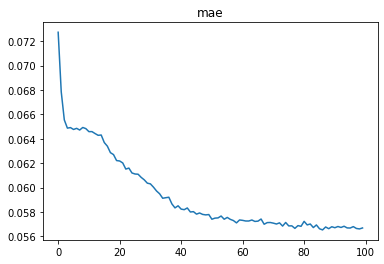

In [7]:
print('timesteps : ',timesteps_)
plt.plot(history.history['mae'])
plt.title('mae')

timesteps :  10


Text(0.5, 1.0, 'mse')

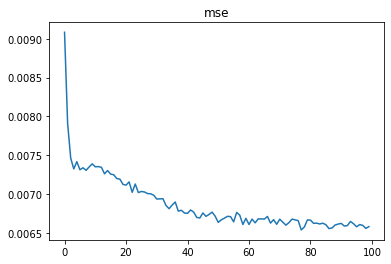

In [8]:
print('timesteps : ',timesteps_)
plt.plot(history.history['mse'])
plt.title('mse')

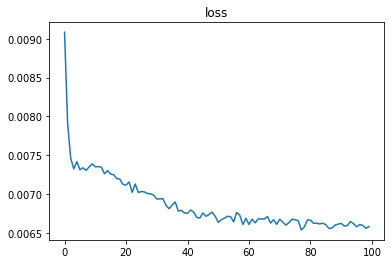

In [9]:
plt.title('loss')
plt.plot(history.history['loss'])

In [10]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
reshape (Reshape)            (None, 10, 1)             0         
_________________________________________________________________
lstm (LSTM)                  (None, 10, 32)            4352      
_________________________________________________________________
dropout (Dropout)            (None, 10, 32)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                

In [11]:
X_test = []
real_value = []

period = timesteps_
end_of_TestSet = test_size

for i in range(period,end_of_TestSet):
    real_value.append(TestSet[i,0])

TestSet = sc.transform(TestSet)

for i in range(period,end_of_TestSet):
    X_test.append(TestSet[i-period:i,0])
    
X_test = np.array(X_test)
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
real_value = np.array(real_value)
predicted_output = model.predict(X_test)

predicted_output.max :  17446.002 , predicted_output.min :  0.0


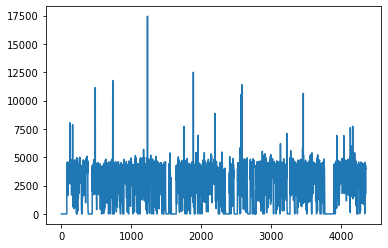

In [12]:
predicted_output = sc.inverse_transform(predicted_output)
#predicted_output = predicted_output * 3
plt.plot(predicted_output)
print('predicted_output.max : ',predicted_output.max(),', predicted_output.min : ',predicted_output.min() )

real_value.max :  23867.0 , real_value.min :  0.0


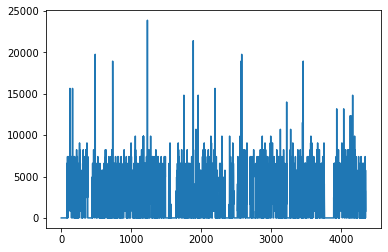

In [13]:
plt.plot(real_value)
print('real_value.max : ',real_value.max(),', real_value.min : ',real_value.min())

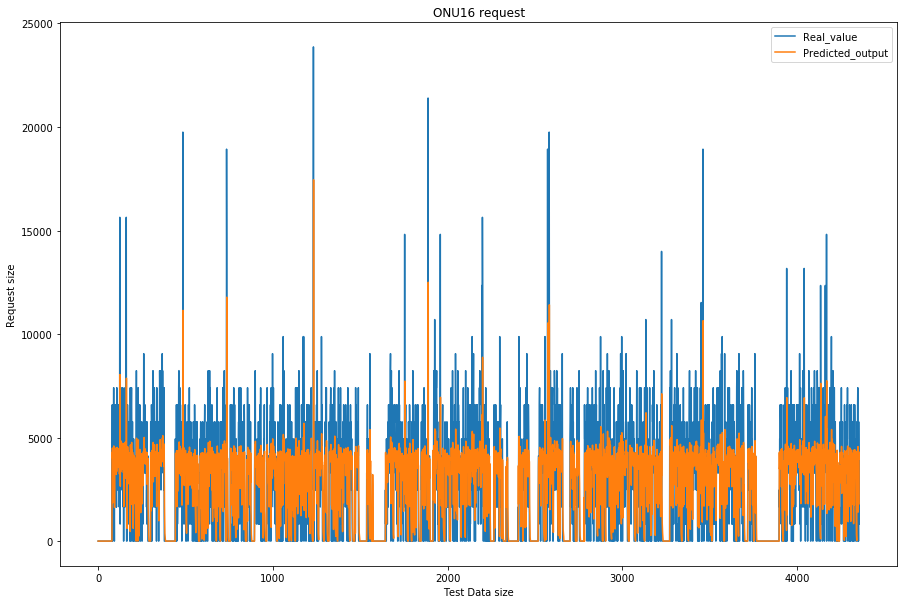

Timesteps :  10
predicted_output.max :  17446.002 , predicted_output.min :  0.0
predicted_output.average :  2706.774
real_value.max :  23867.0 , real_value.min :  0.0
real_value.average :  2711.837
mse :  4984589.226
rmse :  2232.619
mae  :  1542.107875844121


In [14]:
plt.figure(figsize=(15, 10))
plt.plot(real_value,label='Real_value')
plt.plot(predicted_output,label='Predicted_output')
plt.title('ONU16 request')
plt.xlabel("Test Data size")
plt.ylabel("Request size")
plt.legend()
plt.show()
print('Timesteps : ',timesteps_)
print('predicted_output.max : ',predicted_output.max(),', predicted_output.min : ',predicted_output.min())
print('predicted_output.average : ',np.average(predicted_output))
print('real_value.max : ',real_value.max(),', real_value.min : ',real_value.min())
print('real_value.average : ',round(np.average(real_value),3))
from sklearn.metrics import mean_squared_error
mse1 = mean_squared_error(real_value,predicted_output)
print('mse : ',round(mse1,3))
import math
from sklearn.metrics import mean_absolute_error as mae
print('rmse : ',round(math.sqrt(mse1),3))
#print('mae  : ',sum(map(lambda t:float(t[0]-t[1]),zip(predicted_output, real_value)))/len(real_value))
print('mae  : ',mae(real_value, predicted_output))

In [15]:
end = time.time()
print((end - start)/60.0)

3.8305335879325866


In [16]:
print('File Name : ',text_file.name,' , Timesteps : ',timesteps_,', Epochs : ',100,', MSE')

File Name :  ./SelfData/0613/SendReport_ONU16_BufferSize.txt  , Timesteps :  10 , Epochs :  100 , MSE


In [17]:
#model.save('./SelfData/0523/0523_U20D00_ONU16_Ri_195000_1layer_timesteps10.h5', include_optimizer=False)